# Early warning for LHV (beta)

SealGW is able to produce early warning skymap, given SNR timeseries.

Here we give an example using LHV design sensitivities, up to 30s before merger.

*Note:* This function is under development! We need to adapt to SPIIR output in future version.

In [1]:
import bilby
import numpy as np 
import time
import sys
import matplotlib.pyplot as plt
from multiprocessing import Pool
import multiprocessing
from functools import partial
from matplotlib.pyplot import MultipleLocator
from bilby.gw import conversion
from scipy.optimize import leastsq
import json

import sealgw
from sealgw import seal
import sealgw.calculation as sealcal
import sealgw.simulation as sealsim

import pycbc
import pycbc.noise
import pycbc.psd
from pycbc.types import FrequencySeries
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform

from gstlal import chirptime
from bilby.gw import utils as gwutils
from bilby.gw import conversion

from astropy.cosmology import Planck15
import astropy

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Look at horizon for early warning

In [2]:
f_low = 10
duration = 100
sampling_frequency = 4096
nthread = 6

waveform_generator_bns_fd = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters)

waveform_generator_truncated_bns_fd = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=sealgw.simulation.generating_data.bns_truncated_fd_bilbypara,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters)

injection_parameter_bilby = dict(chirp_mass=1.22, mass_ratio=1, a_1=0.02, a_2=0.02, tilt_1=0,tilt_2=0,phi_12=0,phi_jl=0,
                                 lambda_1=425, lambda_2=425,
                                luminosity_distance=1., theta_jn=0, psi=0, phase=0, geocent_time=1187008882.43,
                               ra=1, dec=1, premerger_time=0, flow=10)

injection_parameter_test = dict(chirp_mass=1.22, mass_ratio=1, a_1=0.0, a_2=0.0, lambda_1=425, lambda_2=425,
                                luminosity_distance=1., theta_jn=0, psi=0, phase=0, geocent_time=1187008882.43,
                               ra=1, dec=1, premerger_time=0, flow=10)

ifos = bilby.gw.detector.InterferometerList(['L1', 'H1', 'V1']) #    
for i in range(len(ifos)):
    det = ifos[i]
    det.duration = duration
    det.sampling_frequency=sampling_frequency
    det.f_low = f_low

horizon_list = []
for premergertime in [0,5,10,20,30]:
    injection_parameter_test['premerger_time'] = premergertime
    
    m1, m2 = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(injection_parameter_test['chirp_mass'],
                                                                               injection_parameter_test['mass_ratio'])
    
    if premergertime==0:
        horizon = sealsim.prior_fitting.find_horizon(ifos, waveform_generator_bns_fd, injection_parameter_bilby)
        horizon_list.append(horizon)
        zz = astropy.cosmology.z_at_value(Planck15.luminosity_distance, horizon*astropy.units.Mpc, zmin=1e-5, zmax=3)
        print("pretime = {}s, f_low=/, horizon={:.2f}Mpc, z={:.2f}".format(premergertime, horizon, zz.value))
    else:
        f_low = sealsim.generating_data.premerger_time_to_freq(premergertime,m1,m2)
        #injection_parameter_test['flow'] = 5
        horizon = sealsim.prior_fitting.find_horizon(ifos, waveform_generator_truncated_bns_fd, injection_parameter_test)
        horizon_list.append(horizon)
        if horizon>10:
            zz = astropy.cosmology.z_at_value(Planck15.luminosity_distance, horizon*astropy.units.Mpc, zmin=1e-5, zmax=3)
            print("pretime = {}s, f_low={:.2f}Hz, horizon={:.2f}Mpc, z={:.2f}".format(premergertime, f_low, horizon, zz.value))
        else:
            zz = 0
            print("pretime = {}s, f_low={:.2f}Hz, horizon={:.2f}Mpc, z={:.2f}".format(premergertime, f_low, horizon, zz))

15:01 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters
15:01 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: sealgw.simulation.generating_data.bns_truncated_fd_bilbypara
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


pretime = 0s, f_low=/, horizon=670.81Mpc, z=0.14
pretime = 5s, f_low=72.90Hz, horizon=469.61Mpc, z=0.10
pretime = 10s, f_low=56.22Hz, horizon=402.71Mpc, z=0.09
pretime = 20s, f_low=43.35Hz, horizon=313.95Mpc, z=0.07
pretime = 30s, f_low=37.23Hz, horizon=258.47Mpc, z=0.06


We can see setting f_low=10Hz is enough for LHV early warning.

## Fitting prior for early warning

Skip to next section if you don't want to run it. Fitting results are stored.

In [3]:
seal_bns_ew0s_lhv = seal.Seal() # loc after merger
seal_bns_ew5s_lhv = seal.SealBNSEW(premerger_time=5, f_low=10)
seal_bns_ew10s_lhv = seal.SealBNSEW(premerger_time=10, f_low=10)
seal_bns_ew20s_lhv = seal.SealBNSEW(premerger_time=20, f_low=10)
seal_bns_ew30s_lhv = seal.SealBNSEW(premerger_time=30, f_low=10)

premerger_time = [0,5,10,20,30]

In [23]:
Nsample = 10000
det_name_list = ['L1', 'H1', 'V1']

source_type = "BNS"
ncpu = 6

sealid = 0
for seal_to_train in [seal_bns_ew0s_lhv,seal_bns_ew5s_lhv,seal_bns_ew10s_lhv,seal_bns_ew20s_lhv,seal_bns_ew30s_lhv]:
    pretime = premerger_time[sealid]
    fitting_result = seal_to_train.fitting_mu_sigma_snr_relation(Nsample=Nsample, det_name_list=det_name_list,
                                                                 source_type=source_type, ncpu=ncpu,
                                                                 dmax=horizon_list[sealid]/3 )
    seal_to_train.save_config_dict('example_outputs/config_ew{}s_lhv.txt'.format(pretime))
    sealid+=1

14:43 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


Computing SNR...
Fitting mu-sigma-SNR relation...


14:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


Fitting done!
a = 0.00016418892295217905
b = 0.0007540063347741974
c = 0.00011003003592796502
d = 0.0006770584030156688
Computing SNR...
Fitting mu-sigma-SNR relation...


14:46 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


Fitting done!
a = 0.0001514089045072703
b = 0.0014620329551441231
c = 9.100790087563919e-05
d = 0.0014937553444377897
Computing SNR...
Fitting mu-sigma-SNR relation...


14:47 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


Fitting done!
a = 0.00015354957127739456
b = 0.001715447600187135
c = 9.1513314349374e-05
d = 0.001745424636494323
Computing SNR...
Fitting mu-sigma-SNR relation...


14:48 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


Fitting done!
a = 0.000150419359479667
b = 0.002420270369643086
c = 8.479761980530122e-05
d = 0.0026161743903968756
Computing SNR...
Fitting mu-sigma-SNR relation...
Fitting done!
a = 0.00015189625293519172
b = 0.0029776038705009267
c = 8.932088359594938e-05
d = 0.003054001712803971


<Figure size 432x288 with 0 Axes>

# Localization

In [4]:
# Read from here if you don't want to train
seal_bns_ew0s_lhv = seal.Seal(config_dict = 'example_outputs/config_ew0s_lhv.txt')

seal_bns_ew5s_lhv = seal.SealBNSEW(config_dict = 'example_outputs/config_ew5s_lhv.txt')
seal_bns_ew10s_lhv = seal.SealBNSEW(config_dict = 'example_outputs/config_ew10s_lhv.txt')
seal_bns_ew20s_lhv = seal.SealBNSEW(config_dict = 'example_outputs/config_ew20s_lhv.txt')
seal_bns_ew30s_lhv = seal.SealBNSEW(config_dict = 'example_outputs/config_ew30s_lhv.txt')

premerger_time = [0,5,10,20,30]

15:03 bilby WARNING : The injected signal has a duration in-band of 176.5s, but the data for detector L1 has a duration of 100s
15:03 bilby INFO    : Injected signal in L1:
15:03 bilby INFO    :   optimal SNR = 37.32
15:03 bilby INFO    :   matched filter SNR = 37.55+0.67j
15:03 bilby INFO    :   chirp_mass = 1.22
15:03 bilby INFO    :   mass_ratio = 1
15:03 bilby INFO    :   a_1 = 0.02
15:03 bilby INFO    :   a_2 = 0.02
15:03 bilby INFO    :   tilt_1 = 0
15:03 bilby INFO    :   tilt_2 = 0
15:03 bilby INFO    :   phi_12 = 0
15:03 bilby INFO    :   phi_jl = 0
15:03 bilby INFO    :   lambda_1 = 425
15:03 bilby INFO    :   lambda_2 = 425
15:03 bilby INFO    :   luminosity_distance = 80
15:03 bilby INFO    :   theta_jn = 0
15:03 bilby INFO    :   psi = 0
15:03 bilby INFO    :   phase = 0
15:03 bilby INFO    :   geocent_time = 1187008882.43
15:03 bilby INFO    :   ra = 1
15:03 bilby INFO    :   dec = 1
15:03 bilby WARNING : The injected signal has a duration in-band of 176.5s, but the data 

0s done, SNR=57.1197126098009, timecost 0.5257761478424072(s): 
Search area 0.24 deg^2


15:03 bilby WARNING : The injected signal has a duration in-band of 176.5s, but the data for detector L1 has a duration of 100s
15:03 bilby INFO    : Injected signal in L1:
15:03 bilby INFO    :   optimal SNR = 26.48
15:03 bilby INFO    :   matched filter SNR = 24.84-0.01j
15:03 bilby INFO    :   chirp_mass = 1.22
15:03 bilby INFO    :   mass_ratio = 1
15:03 bilby INFO    :   a_1 = 0.02
15:03 bilby INFO    :   a_2 = 0.02
15:03 bilby INFO    :   tilt_1 = 0
15:03 bilby INFO    :   tilt_2 = 0
15:03 bilby INFO    :   phi_12 = 0
15:03 bilby INFO    :   phi_jl = 0
15:03 bilby INFO    :   lambda_1 = 425
15:03 bilby INFO    :   lambda_2 = 425
15:03 bilby INFO    :   luminosity_distance = 80
15:03 bilby INFO    :   theta_jn = 0
15:03 bilby INFO    :   psi = 0
15:03 bilby INFO    :   phase = 0
15:03 bilby INFO    :   geocent_time = 1187008882.43
15:03 bilby INFO    :   ra = 1
15:03 bilby INFO    :   dec = 1
15:03 bilby INFO    :   premerger_time = 5
15:03 bilby INFO    :   flow = 10
15:03 bilby 

Skymap saved to example_outputs/skymap_LHVew_0s.png
5s done, SNR=39.27101773465506, timecost 0.5679051876068115(s): 
Search area 5.70 deg^2


15:03 bilby WARNING : The injected signal has a duration in-band of 176.5s, but the data for detector L1 has a duration of 100s
15:03 bilby INFO    : Injected signal in L1:
15:03 bilby INFO    :   optimal SNR = 23.09
15:03 bilby INFO    :   matched filter SNR = 22.34-1.41j
15:03 bilby INFO    :   chirp_mass = 1.22
15:03 bilby INFO    :   mass_ratio = 1
15:03 bilby INFO    :   a_1 = 0.02
15:03 bilby INFO    :   a_2 = 0.02
15:03 bilby INFO    :   tilt_1 = 0
15:03 bilby INFO    :   tilt_2 = 0
15:03 bilby INFO    :   phi_12 = 0
15:03 bilby INFO    :   phi_jl = 0
15:03 bilby INFO    :   lambda_1 = 425
15:03 bilby INFO    :   lambda_2 = 425
15:03 bilby INFO    :   luminosity_distance = 80
15:03 bilby INFO    :   theta_jn = 0
15:03 bilby INFO    :   psi = 0
15:03 bilby INFO    :   phase = 0
15:03 bilby INFO    :   geocent_time = 1187008882.43
15:03 bilby INFO    :   ra = 1
15:03 bilby INFO    :   dec = 1
15:03 bilby INFO    :   premerger_time = 10
15:03 bilby INFO    :   flow = 10
15:03 bilby

Skymap saved to example_outputs/skymap_LHVew_5s.png
10s done, SNR=33.77094381166318, timecost 0.5840308666229248(s): 
Search area 1.26 deg^2


15:03 bilby WARNING : The injected signal has a duration in-band of 176.5s, but the data for detector L1 has a duration of 100s
15:03 bilby INFO    : Injected signal in L1:
15:03 bilby INFO    :   optimal SNR = 18.42
15:03 bilby INFO    :   matched filter SNR = 17.41+0.09j
15:03 bilby INFO    :   chirp_mass = 1.22
15:03 bilby INFO    :   mass_ratio = 1
15:03 bilby INFO    :   a_1 = 0.02
15:03 bilby INFO    :   a_2 = 0.02
15:03 bilby INFO    :   tilt_1 = 0
15:03 bilby INFO    :   tilt_2 = 0
15:03 bilby INFO    :   phi_12 = 0
15:03 bilby INFO    :   phi_jl = 0
15:03 bilby INFO    :   lambda_1 = 425
15:03 bilby INFO    :   lambda_2 = 425
15:03 bilby INFO    :   luminosity_distance = 80
15:03 bilby INFO    :   theta_jn = 0
15:03 bilby INFO    :   psi = 0
15:03 bilby INFO    :   phase = 0
15:03 bilby INFO    :   geocent_time = 1187008882.43
15:03 bilby INFO    :   ra = 1
15:03 bilby INFO    :   dec = 1
15:03 bilby INFO    :   premerger_time = 20
15:03 bilby INFO    :   flow = 10
15:03 bilby

Skymap saved to example_outputs/skymap_LHVew_10s.png
20s done, SNR=27.77169342602856, timecost 0.5783202648162842(s): 
Search area 1.27 deg^2


15:03 bilby WARNING : The injected signal has a duration in-band of 176.5s, but the data for detector L1 has a duration of 100s
15:03 bilby INFO    : Injected signal in L1:
15:03 bilby INFO    :   optimal SNR = 15.36
15:03 bilby INFO    :   matched filter SNR = 16.68+1.66j
15:03 bilby INFO    :   chirp_mass = 1.22
15:03 bilby INFO    :   mass_ratio = 1
15:03 bilby INFO    :   a_1 = 0.02
15:03 bilby INFO    :   a_2 = 0.02
15:03 bilby INFO    :   tilt_1 = 0
15:03 bilby INFO    :   tilt_2 = 0
15:03 bilby INFO    :   phi_12 = 0
15:03 bilby INFO    :   phi_jl = 0
15:03 bilby INFO    :   lambda_1 = 425
15:03 bilby INFO    :   lambda_2 = 425
15:03 bilby INFO    :   luminosity_distance = 80
15:03 bilby INFO    :   theta_jn = 0
15:03 bilby INFO    :   psi = 0
15:03 bilby INFO    :   phase = 0
15:03 bilby INFO    :   geocent_time = 1187008882.43
15:03 bilby INFO    :   ra = 1
15:03 bilby INFO    :   dec = 1
15:03 bilby INFO    :   premerger_time = 30
15:03 bilby INFO    :   flow = 10
15:03 bilby

Skymap saved to example_outputs/skymap_LHVew_20s.png


15:03 bilby INFO    :   lambda_2 = 425
15:03 bilby INFO    :   luminosity_distance = 80
15:03 bilby INFO    :   theta_jn = 0
15:03 bilby INFO    :   psi = 0
15:03 bilby INFO    :   phase = 0
15:03 bilby INFO    :   geocent_time = 1187008882.43
15:03 bilby INFO    :   ra = 1
15:03 bilby INFO    :   dec = 1
15:03 bilby INFO    :   premerger_time = 30
15:03 bilby INFO    :   flow = 10


30s done, SNR=23.476148957243737, timecost 0.5749201774597168(s): 
Search area 106.28 deg^2
Skymap saved to example_outputs/skymap_LHVew_30s.png


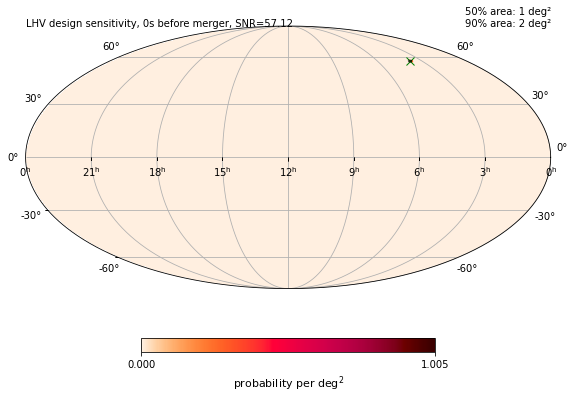

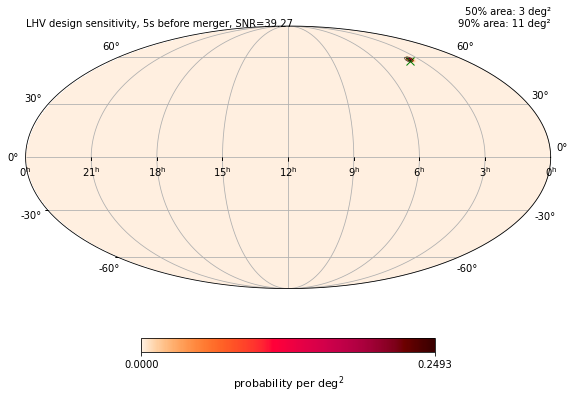

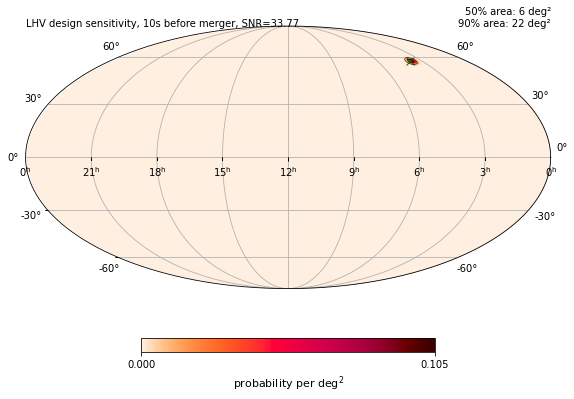

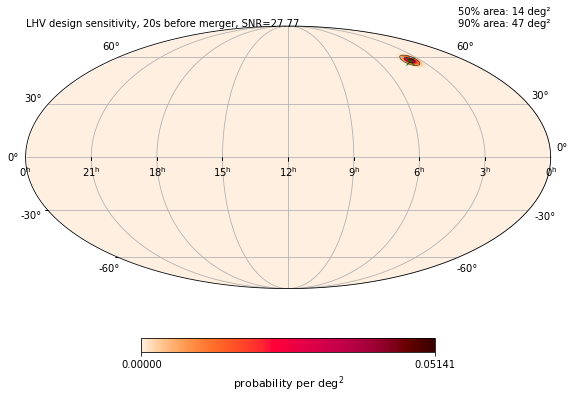

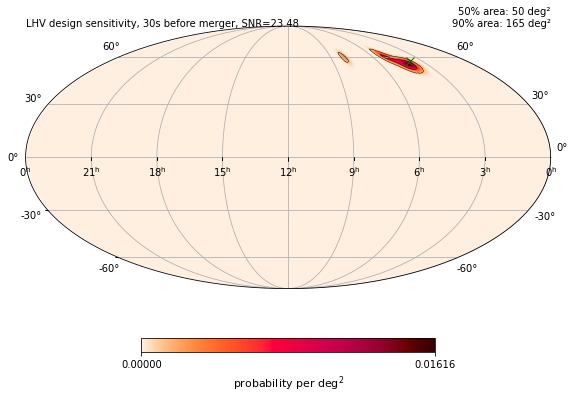

In [8]:
sealid = 0
injection_parameter_bilby['luminosity_distance'] = 80
for seal_to_train in [seal_bns_ew0s_lhv,seal_bns_ew5s_lhv,seal_bns_ew10s_lhv,seal_bns_ew20s_lhv,seal_bns_ew30s_lhv]:
    pretime = premerger_time[sealid]
    injection_parameter_bilby['premerger_time'] = pretime

    ifos = bilby.gw.detector.InterferometerList(['L1', 'H1', 'V1']) #
    
    # set detector paramaters
    for i in range(len(ifos)):
        det = ifos[i]
        det.duration = duration
        det.sampling_frequency=sampling_frequency
        det.f_low = f_low

    ifos.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_frequency, duration=duration,
        start_time=injection_parameter_bilby['geocent_time'] - duration + 1)

    if pretime==0:
        injection_parameter_bilby_0 = injection_parameter_bilby.copy()
        injection_parameter_bilby_0['tilt_1'] = 0
        injection_parameter_bilby_0['tilt_2'] = 0
        injection_parameter_bilby_0['phi_12'] = 0
        injection_parameter_bilby_0['phi_jl'] = 0
        injection_parameter_bilby_0.pop('premerger_time')
        injection_parameter_bilby_0.pop('flow')
        ifos.inject_signal(waveform_generator=waveform_generator_bns_fd,
                parameters=injection_parameter_bilby_0, raise_error=False)
        snr_list, sigma_list = sealsim.generating_data.snr_generator(ifos, waveform_generator_bns_fd, injection_parameter_bilby_0)
    else:
        injection_parameter_bilby_0 = injection_parameter_bilby.copy()
        injection_parameter_bilby_0['geocent_time'] = injection_parameter_bilby_0['geocent_time']# - pretime
        ifos.inject_signal(waveform_generator=waveform_generator_truncated_bns_fd,
                parameters=injection_parameter_bilby_0, raise_error=False)
    
        snr_list, sigma_list = sealsim.generating_data.snr_generator(ifos, waveform_generator_truncated_bns_fd, injection_parameter_bilby_0)
    
    max_snr_sq = 0
    det_names = ['L1', 'H1', 'V1']
    det_id = 0
    for snr in snr_list:
        peak = abs(snr).numpy().argmax()
        snrp = snr[peak]
        max_snr_sq += abs(snrp)**2


    # Rearrange some variables: snr_arrays, time_arrays are 1-D array
    time_arrays = np.array([])
    snr_arrays = np.array([])
    ntimes_array = np.array([])
    for snr in snr_list:
        snr_arrays = np.append(snr_arrays, snr.data)
        time_arrays = np.append(time_arrays, snr.sample_times.data)
        ntimes_array = np.append(ntimes_array, len(snr.sample_times.data))

    max_snr = max_snr_sq**0.5
    sigma_array = np.array(sigma_list)

    start_time = injection_parameter_bilby['geocent_time'] - 0.01
    end_time = injection_parameter_bilby['geocent_time'] + 0.01

    logprob_skymap, timecost = seal_to_train.localize( det_names, time_arrays, snr_arrays,
                                                      max_snr, sigma_array, ntimes_array, start_time, end_time,
                                                      nthread,  timecost=True, interp_factor=5)

    print("{}s done, SNR={}, timecost {}(s): ".format(pretime,max_snr,timecost))
    true_ra = injection_parameter_bilby['ra']
    true_dec = injection_parameter_bilby['dec']
    print("Search area {:.2f} deg^2".format(sealcal.localization.search_area(logprob_skymap, true_ra, true_dec)))
    save_filename = 'example_outputs/skymap_LHVew_{}s.png'.format(pretime)
    add_text = 'LHV design sensitivity, {}s before merger, SNR={:.2f}'.format(pretime,max_snr)
    fig = sealcal.localization.plot_skymap(logprob_skymap, true_ra = true_ra, true_dec = true_dec, save_filename=save_filename, additional_text=add_text)
    sealid+=1

# Make gif

In [9]:
import imageio.v2 as imageio
images = []


filenames =['example_outputs/skymap_LHVew_30s.png',
 'example_outputs/skymap_LHVew_20s.png',
 'example_outputs/skymap_LHVew_10s.png',
 'example_outputs/skymap_LHVew_5s.png',
 'example_outputs/skymap_LHVew_0s.png']
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('example_outputs/ew_example_skymap.gif', images, duration=1,)